# **Modelling and Evaluation**

---

## Objectives

* Answer business requirement 2:
    * Develop a machine learning model for automating image categorization, leveraging CNN architecture for efficient and scalable classification.

* Answer Business Requirement 3:
    * Assess model performance using accuracy, precision, recall, F1-score, and a confusion matrix to ensure high accuracy and effectiveness in predictions.

## Inputs

* inputs/cifar10_dataset_small/train
* inputs/cifar10_dataset_small/validation
* inputs/cifar10_dataset_small/test
* image shape embeddings

## Outputs

* Class distribution plots for training, validation, and test sets.
* Image augmentation
* Development and training of the machine learning model
* Learning curve plot for model performance.
* Model evaluation saved as a pickle file.

---

## Install packages and libraries

In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread
import pickle


## Change and Set directories

We need to change the working directory from its current folder to its parent folder


In [2]:
current_dir = os.getcwd()
print('Current folder: ' + current_dir)
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print('New folder: ' + current_dir)

Current folder: /workspace/SnapSortAI/jupyter_notebooks
New folder: /workspace/SnapSortAI


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/SnapSortAI'

### Input directories and paths

In [4]:
dataset_root_dir = 'inputs/cifar10_dataset_small'
train_path = dataset_root_dir + '/train'
validation_path = dataset_root_dir + '/validation'
test_path = dataset_root_dir + '/test'
train_path

'inputs/cifar10_dataset_small/train'

### Set output directory

In [5]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print(f'Version {version} is already available.')
    pass
else:
    os.makedirs(name=file_path)
    print(f'New directory for version {version} has been created')

Version v1 is already available.


### Set label names

In [6]:
labels = os.listdir(train_path)
labels.sort()
print("Class names:", labels)

Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Set image shape

In [7]:
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(32, 32, 3)

---

## Image Distribution in Train, Test and Validation Data

---

Let's recap on the plot from the previous notebook:

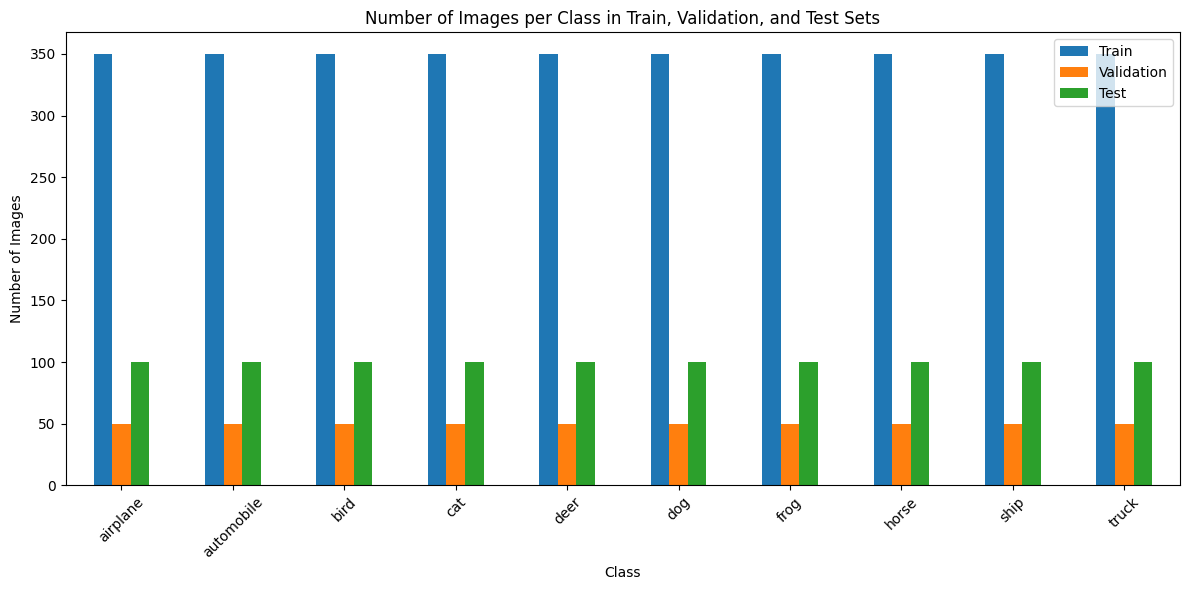

In [8]:
def count_images_in_path(path):
    class_counts = {}
    for label in labels:
        label_path = os.path.join(path, label)
        class_counts[label] = len(os.listdir(label_path))
    return class_counts

# Count images in train, validation, and test sets
train_counts = count_images_in_path(train_path)
validation_counts = count_images_in_path(validation_path)
test_counts = count_images_in_path(test_path)

# Convert to DataFrame for plotting
train_df = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Train'])
validation_df = pd.DataFrame(list(validation_counts.items()), columns=['Class', 'Validation'])
test_df = pd.DataFrame(list(test_counts.items()), columns=['Class', 'Test'])

# Merge dataframes for visualization
df = pd.merge(train_df, validation_df, on='Class')
df = pd.merge(df, test_df, on='Class')

# Plot the number of images per class for train, validation, and test sets
df.set_index('Class').plot(kind='bar', figsize=(12, 6))
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Train, Validation, and Test Sets')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

---

## Image Data Augmentation

---

### Initialize image data generator

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Augment training, validation and test image datasets

In [10]:
batch_size = 20

train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

train_set.class_indices

Found 3500 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

### Plot augmented training image

(20, 32, 32, 3)


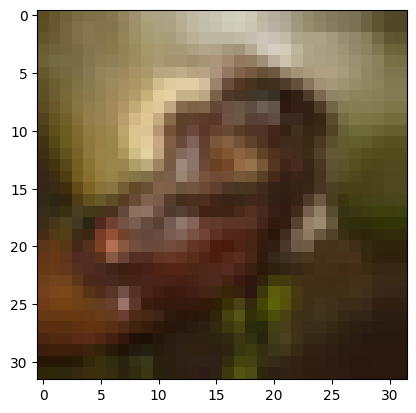

(20, 32, 32, 3)


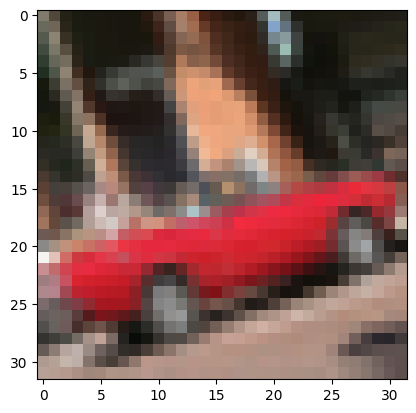

(20, 32, 32, 3)


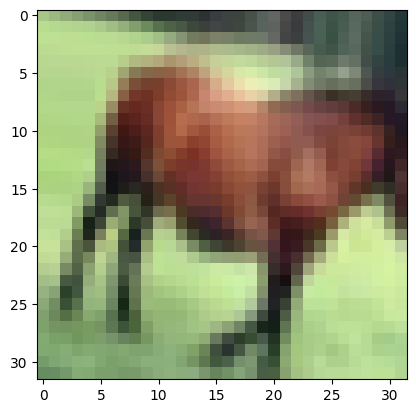

In [11]:
# Training set
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Plot augmented validation and test images

(20, 32, 32, 3)


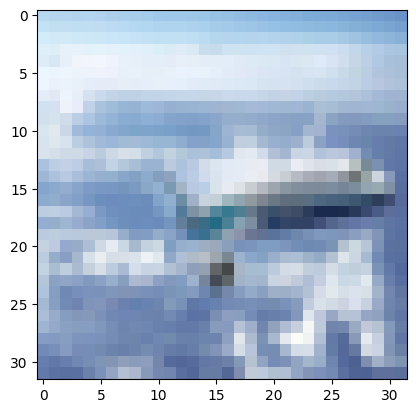

(20, 32, 32, 3)


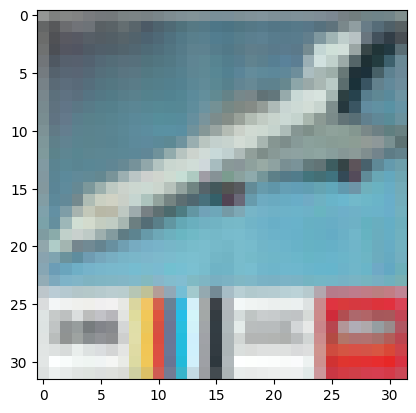

(20, 32, 32, 3)


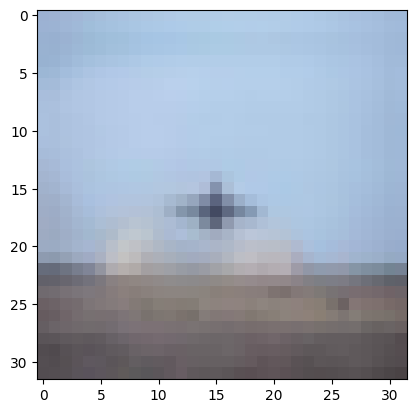

(20, 32, 32, 3)


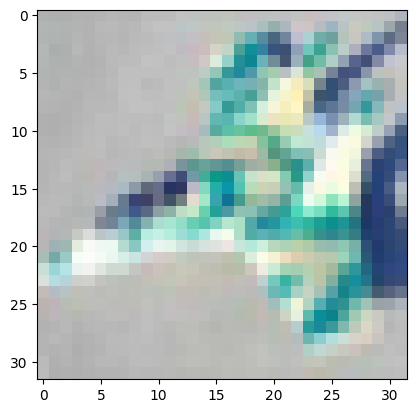

(20, 32, 32, 3)


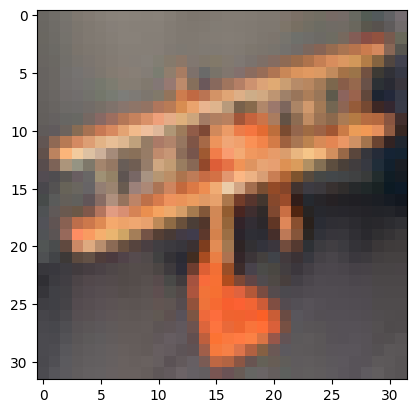

(20, 32, 32, 3)


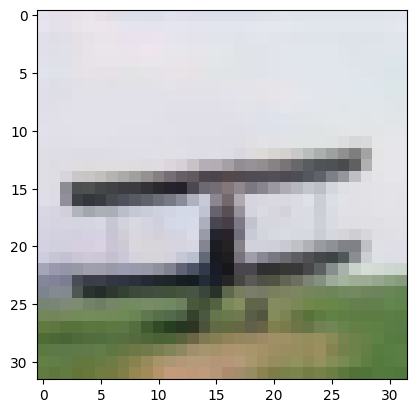

In [12]:
# Validation set
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

# Test set
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()


### Save class indicies

In [13]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Model Creation

---

### ML model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


### Summary

In [20]:

create_tf_model().summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

2024-09-20 11:54:34.967129: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Early Stopping

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Fit Model For Model Training

In [22]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2024-09-20 11:54:45.194030: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
175/175 [==============================] - 6s 32ms/step - loss: 2.2328 - accuracy: 0.1457 - val_loss: 2.0630 - val_accuracy: 0.2280
Epoch 2/25
175/175 [==============================] - 5s 31ms/step - loss: 2.0867 - accuracy: 0.2040 - val_loss: 1.9605 - val_accuracy: 0.2360
Epoch 3/25
175/175 [==============================] - 5s 31ms/step - loss: 2.0026 - accuracy: 0.2377 - val_loss: 1.8920 - val_accuracy: 0.2700
Epoch 4/25
175/175 [==============================] - 5s 31ms/step - loss: 1.9321 - accuracy: 0.2717 - val_loss: 1.7743 - val_accuracy: 0.3140
Epoch 5/25
175/175 [==============================] - 6s 34ms/step - loss: 1.8683 - accuracy: 0.2934 - val_loss: 1.7464 - val_accuracy: 0.3300
Epoch 6/25
175/175 [==============================] - 6s 33ms/step - loss: 1.8208 - accuracy: 0.3123 - val_loss: 1.7981 - val_accuracy: 0.3080
Epoch 7/25
175/175 [==============================] - 5s 31ms/step - loss: 1.8051 - accuracy: 0.3234 - val_loss: 1.7652 - val_accuracy: 0.3240

### Save Model

In [23]:
model.save(f'{file_path}/snapsort_model.h5')

---

## Model Performance

---

### Model Learning Curve

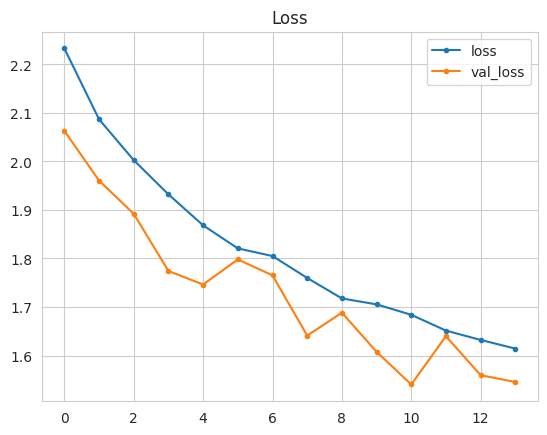

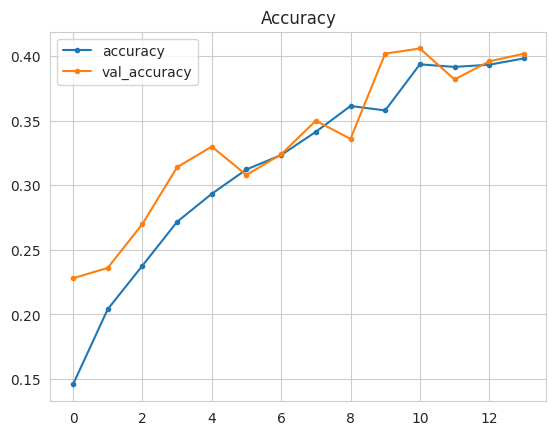

In [24]:

losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Model Evaluation

#### Load model

In [25]:
from keras.models import load_model
model = load_model(f'{file_path}/snapsort_model.h5')

#### Evaluate on the test set

In [26]:
evaluation = model.evaluate(test_set)

50/50 [==============================] - 1s 8ms/step - loss: 1.6407 - accuracy: 0.4040


#### Save Evaluation

In [27]:
joblib.dump(value=evaluation,
            filename=f'{file_path}/evaluation.pkl')

['outputs/v1/evaluation.pkl']

### Predict On New Data

#### Load a random image as PIL

Image shape: (32, 32), Image mode: RGB


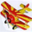

In [28]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

#### Convert image to array

In [29]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 32, 32, 3)


#### Predict class for the image

Predicted Probabilities: [0.01189621 0.18741103 0.00183152 0.00318583 0.00111428 0.00221699
 0.00123015 0.0047899  0.01228445 0.7740396 ]
Predicted Class: airplane


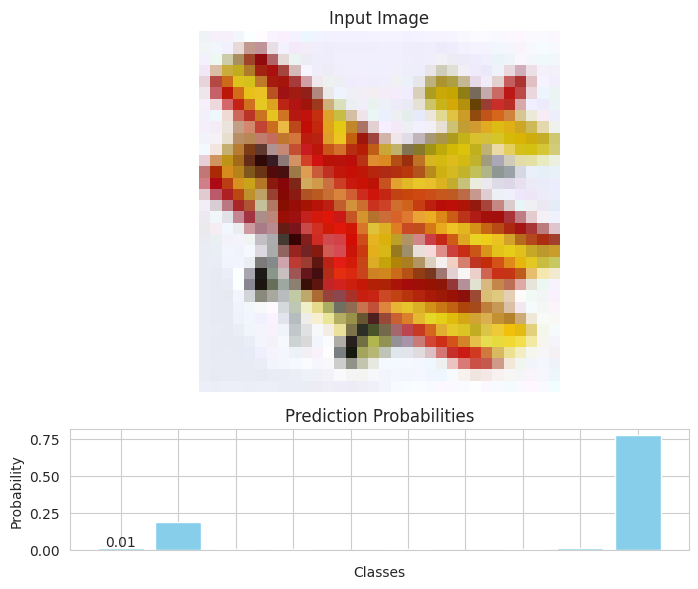

In [37]:
# Predict class probabilities for all classes
pred_proba = model.predict(my_image)[0]

# Map indices to class names
target_map = {v: k for k, v in train_set.class_indices.items()}

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(pred_proba[0])
pred_class = target_map[predicted_class_index]

# Print the predicted probabilities and predicted class
print("Predicted Probabilities:", pred_proba)
print("Predicted Class:", pred_class)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(7, 6), gridspec_kw={'height_ratios': [3, 1]})

# Display the input image
axs[0].imshow(pil_image)
axs[0].set_title('Input Image')
axs[0].axis('off')

# Plot the prediction probabilities
axs[1].bar(range(len(labels)), pred_proba, color='skyblue')
axs[1].set_title('Prediction Probabilities')
axs[1].set_xlabel('Classes')
axs[1].set_ylabel('Probability')

# Show class labels (including only the predicted class name)
labels_to_display = [label if label == pred_class else '' for label in labels]
axs[1].set_xticks(range(len(labels)))
axs[1].set_xticklabels(labels_to_display, rotation=90)

# Add the probability value next to the bar for the top breed
axs[1].text(predicted_class_index, pred_proba[predicted_class_index] + 0.01, 
            f'{pred_proba[predicted_class_index]:.2f}', ha='center')

plt.tight_layout()
plt.show()

---

## Push Files To Repo

Add to gitignore:

View changed files:

In [ ]:
!git status

Add, commit and push your files to the repo (all or single files):

In [ ]:
!git add .

!git commit -m "Message"

!git push

---

## Conclusions

---

**Model v1:**